# Réalisation d'apprentissage personnalisé sous TF 
## P. Carré XLIM, Université de Poitiers

Dans le cadre de l'apprentissage par renforcement (version Deep), il est nécessaire de pouvoir déployer une boucle d'apprentissage avec rétroporapagation du gradient personnalisée.
L'objectif de ce Notbook est d'illustrer les concepts de base permettant de faire cela.

### Premier exemple : modèle direct d'un neurone
Nous proposons d'illustrer le concept avec un simple neurone sans usage des fonctions TF associées aux layers de TF 

In [2]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

import numpy as np
import random

In [3]:
def calcul_u(w,x): # fonction calculant la sortie intermédiaire du réseau
    return w[0]+w[1]*x[0]+w[2]*x[1]

In [4]:
@tf.custom_gradient # on va définir la dérivé de la fonction d'activation
#Concept du décorateur de fonction,  modifier le comportement d'une fonction de manière temporaire
def mytanh(u):
  y = tf.math.tanh(u) #fonction d'activation tanh
  def grad(err):
    return err * (1 - y*y) #definition du gradient qui mutliplie l'erreur durant la rétropropagation
  return y , grad

Maintenant nous pouvons définir notre exemple dans le cadre du OU

In [5]:
x=tf.constant(np.transpose([[0.,0.],[0.,1.],[1.,0.],[1.,1.]])) #Data 
yd=tf.constant(np.array([-1.,1.,1.,1.])) #Les réponses désirées
w= tf.Variable(np.random.rand(3)-0.5) #Les poids

On peut remarquer que la définition de toutes les variables se fait à travers le formalisme TF, cela permettra ensuite
d'appliquer la rétropropagation du gradient.

In [6]:
epoch = 100
#optimizer = keras.optimizers.SGD(learning_rate=0.1) #On choisit un optimiser 
optimizer = tf.keras.optimizers.SGD(learning_rate=0.1)
suivi = np.zeros(epoch)
loss_fn = keras.losses.mean_squared_error #utilisation de la fonction de cout MSE

Quelques éléments concernant la rétroporapagation du gradient avec TF et tf.GradientTape()
#automatic differentiation
#computing the gradient of a computation with respect to its input variables.
#Tensorflow "records" all operations executed inside the context of a tf.GradientTape onto a "tape". 
#Tensorflow then uses that tape and the gradients associated with each recorded operation 
#to compute the gradients of a "recorded" computation using reverse mode differentiation.
#https://www.tensorflow.org/guide/autodiff

Pour différencier automatiquement, TensorFlow doit se rappeler quelles opérations se produisent dans quel ordre pendant le passage vers l' avant . Ensuite, lors de la passe arrière , TensorFlow parcourt cette liste d'opérations dans l'ordre inverse pour calculer les gradients.

TensorFlow fournit l'API tf.GradientTape pour la différenciation automatique ; c'est-à-dire calculer le gradient d'un calcul par rapport à certaines entrées, généralement tf.Variable s. TensorFlow "enregistre" les opérations pertinentes exécutées dans le contexte d'un tf.GradientTape sur une "bande". TensorFlow utilise ensuite cette bande pour calculer les gradients d'un calcul "enregistré" en utilisant la différenciation en mode inverse .

In [7]:
for nbre in range(0,epoch): # pour chaque epoch
    for b in range(0,4): 
        indiv = x[:,b] # pour chaque individu
        target = yd[b] # associé à une réponse désirée
        with tf.GradientTape() as tape: 
            #Pour que le système puisse faire la descente de gradient
            #il faut recalculer la propagation de l'entrée
            #Ce que l'on pense obtenir
            u_pred = calcul_u(w,indiv)
            y_pred = mytanh(u_pred) #Ce que l'on pense obteni
            loss = loss_fn([target],[y_pred]) # On peut calculer la différence, cela doit être une liste 
            
        gradients = tape.gradient(loss,[w]) #calcul du gradient de la focntion loss en fonction des variables du modèle 
        # A ce stade on a la valeur du gradient en focntion de chaque variable
        optimizer.apply_gradients(zip(gradients,[w])) #On combine (valeur gradient ; paramètre associé) et on applique la modification
        suivi[nbre] += loss.numpy() # on récupère la valeur pour afficher l'évolution de l'erreur

Maintenant nous pouvons évaluer le résultat de l'apprentissage en regardant la sortie pour les 4 couples binaires et afficher 
l'évolution de l'erreur

-0.7961154817554776
0.8786089271231414
0.8760503103077814
0.9990312295058197


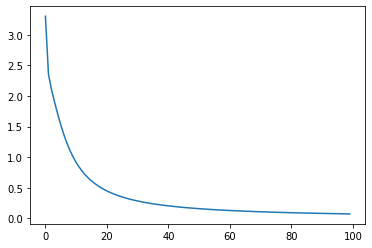

In [8]:
print(mytanh(calcul_u(w,x[:,0])).numpy())
print(mytanh(calcul_u(w,x[:,1])).numpy())
print(mytanh(calcul_u(w,x[:,2])).numpy())
print(mytanh(calcul_u(w,x[:,3])).numpy())
plt.plot(suivi)

## Test sur une structure neuronale plus complexe
Nous proposons d'étudier le principe de la boucle personnalisée à partir d'une structure composée de plusieurs couches.
Nous illsutrons cela dans le contexte d'un problème de régression

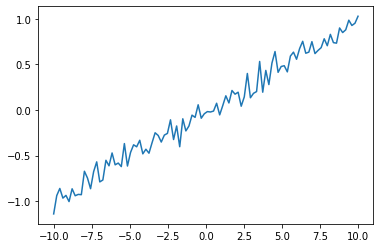

In [9]:
# # Données de test y = x*a
#b du bruit
N = 100 #nbre individu
x = np.linspace(-10, 10, num=N)
oracle = 0.1*x + 0.1*np.random.normal(size=N)
plt.plot(x,oracle)

In [10]:
#tf.keras.backend.set_floatx('float64')
model = keras.Sequential()
model.add(keras.layers.Dense(units = 8, activation = 'linear', input_shape=[1]))
model.add(keras.layers.Dense(units = 16, activation = 'relu'))
model.add(keras.layers.Dense(units = 1, activation = 'linear'))

In [11]:
epoch = 10
optimizer = keras.optimizers.Nadam(learning_rate=1e-3) #On choisit un optimiser 
suivi = np.zeros(epoch)
loss_fn = keras.losses.mean_squared_error #utilisation de la fonction de cout MSE

In [12]:
indiv = np.zeros((1,1))

for nbre in range(0,epoch): # pour chaque epoch
    gstoch = np.random.permutation(N) #présentation ordre aléatoire
    data = x[gstoch]
    yd = oracle[gstoch]
    for b in range(0,N): 
        indiv[0,0] = data[b] # pour chaque individu
        target = yd[b] # associé à une réponse désirée
        with tf.GradientTape() as tape: 
            #Pour que le système puisse faire la descente de gradient
            #il faut calculer la propagation de l'entrée
            #Ce que l'on pense obtenir
            predict = model(indiv) #Ce que l'on pense obteni
            loss = loss_fn([target],[predict]) # On peut calculer la différence, cela doit être une liste 
        
        gradients = tape.gradient(loss,model.trainable_variables) #calcul du gradient de la focntion loss en fonction des variables du modèle 
        # A ce stade on a la valeur du gradient en focntion de chaque variable
        optimizer.apply_gradients(zip(gradients,model.trainable_variables)) #On combine (valeur gradient ; paramètre associé) et on applique la modification
        suivi[nbre] += loss.numpy() # on récupère la valeur pour afficher l'évolution de l'erreur


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



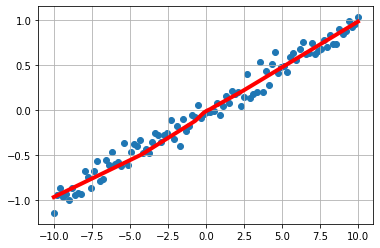

In [13]:
y_predicted = model.predict(x)

# Display the result
plt.scatter(x[::1], oracle[::1])
plt.plot(x, y_predicted, 'r', linewidth=4)
plt.grid()
plt.show()